[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahmouddraz/xai/blob/main/notebooks/saliency_map/saliency_map_solutions.ipynb)

# Saliency MAP

**Activation map**: shows the learned features (take it form the last Conv and multiply with the weights)
**Saliency map**: calculate the change in gradient of loss over pixles 
(GRAD-CAM) does not need special cnn architecture - this is the only advantage it offers  

In [ ]:
import tensorflow as tf 
import tensorflow_hub as hub 
import cv2
import numpy as np 
import matplotlib.pyplot as plt 

## Import pretrained model from tensorflow hub

In [ ]:
model = tf.keras.Sequential(
    [hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4'), 
     tf.keras.layers.Activation('softmax')
     
    ]
)

model.build([None, 300, 300, 3])

## Get an image for testing

In [ ]:
!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

## Prepare the image

In [ ]:
# read image with cv2
image = cv2.imread('image.jpg')
print(image.shape)
# formate the image to be in the RGB colort space
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# resiee the image to match the input shape of the mode (300, 300, 3)
image = cv2.resize(image, (300, 300))
# Normalize the image to color values or the pixles to be from 1 - 0 
image = image / 255.0
## add one more dimention to the image to match the model input layer, ie (None, 300, 300, 3)
img = np.expand_dims(image, axis=0)
print(img.shape)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show

## Claculate Gradients

In [ ]:
# we need the id index of the class we want to explain
class_index = 251

# total number of the classes that are in ImageNet datasets
num_classes = 1001

# conver the image to a tensor that fits the input to the softmax 
# sotmax will convert it then to a vector probrabilities 
expected_output = tf.one_hot([class_index] * img.shape[0], num_classes)

In [ ]:
## apply gradeintap to trace the change of the loss function over the pixles 
## the lower loss comprosnords to relavnce to the decision 

with tf.GradientTape() as tape: 

  # convert the vlaues in the image array to float32
  inputs = tf.cast(img, tf.float32)

  # ask the tap to record the
  tape.watch(inputs)

  # apply the model to predict 
  pred = model(inputs)

  # calculaet the loss (compare the pred to the orginal label)
  loss = tf.keras.losses.categorical_crossentropy(expected_output, pred)

# calculaet the change in the loss to the pixles (gradients)
gradients = tape.gradient(loss, img)


In [ ]:
print(gradients.shape)

TensorShape([1, 300, 300, 3])

# Overlay the gradniets map over the image

In [ ]:
# reverse the preprocessing of the image
grayscale_gradients = tf.reduce_sum(tf.abs(gradients), axis=-1)

print("grayscale_shape", grayscale_gradients.shape)

# we would like to make sure the the gradients are scllaed to image scale (0-255)
## [55 9] --> [55 9] - [9 9] = [46 0] / [[55 55 ] - [9 9]] = [1 0] * 255 -->> [255 0]
numeritor = grayscale_gradients - tf.reduce_min(grayscale_gradients)
denomirator = tf.reduce_max(grayscale_gradients) - tf.reduce_min(grayscale_gradients)
normalized_grandient = tf.cast(255 * numeritor / denomirator, dtype=tf.uint8)
normalized_grandient = tf.squeeze(normalized_grandient)

print("normalized gradniet shape", normalized_grandient.shape)

TensorShape([1, 300, 300])

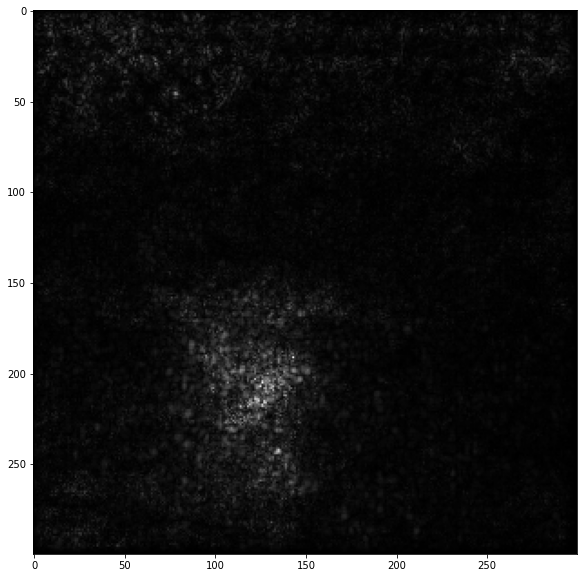

In [ ]:
## plot the grayscale 
plt.figure(figsize=(10,10))
plt.imshow(normalized_grandient, cmap='gray')

<function matplotlib.pyplot.show>

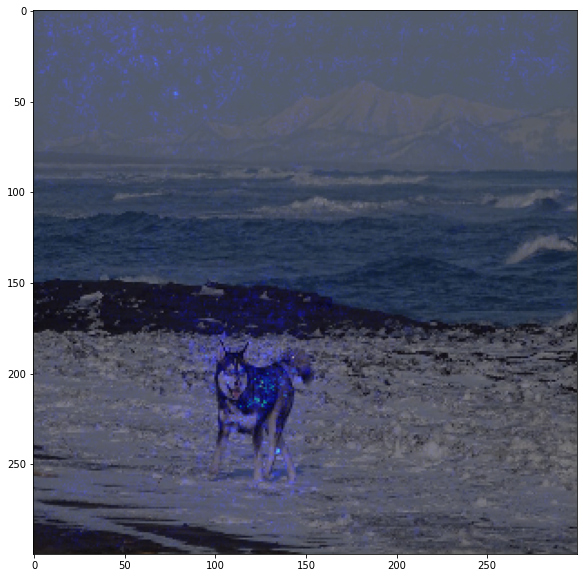

In [ ]:
gradinet_color = cv2.applyColorMap(normalized_grandient.numpy(), cv2.COLORMAP_HOT) / 255.0 
super_imposed = cv2.addWeighted(src1=image, alpha=0.5, src2=gradinet_color, beta=0.5, gamma=0)


plt.figure(figsize=(10,10))
plt.imshow(super_imposed)
plt.show 